In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv

In [2]:
#To remove warnings
pd.options.mode.chained_assignment = None  # default='warn' 

## Summary

The main purpose of this notebook is to create a PARTNER x ROLE (RLTYP) matrix using BUT100.csv. BUT100 contains the information for business partner roles. The roles indicate what role a partner plays in its relationship with the university. This can be a LUF contact, an alumnus, an employee, etc. <br>
There are only 2 features in BUT100. <b>'PARTNER'</b> indicates the business partner, <b>'RLTYP'</b> is the role code. <br>
A business partner can play multiple roles. <br>
The PARTNER x ROLE (RLTYP) matrix can be used as features for classifying donors who donates only once to Leuven University Fund (LUF) and donors who donates more than once to LUF.<br>
<br>

The partner roles that is considered by LUF is shown in the table below:

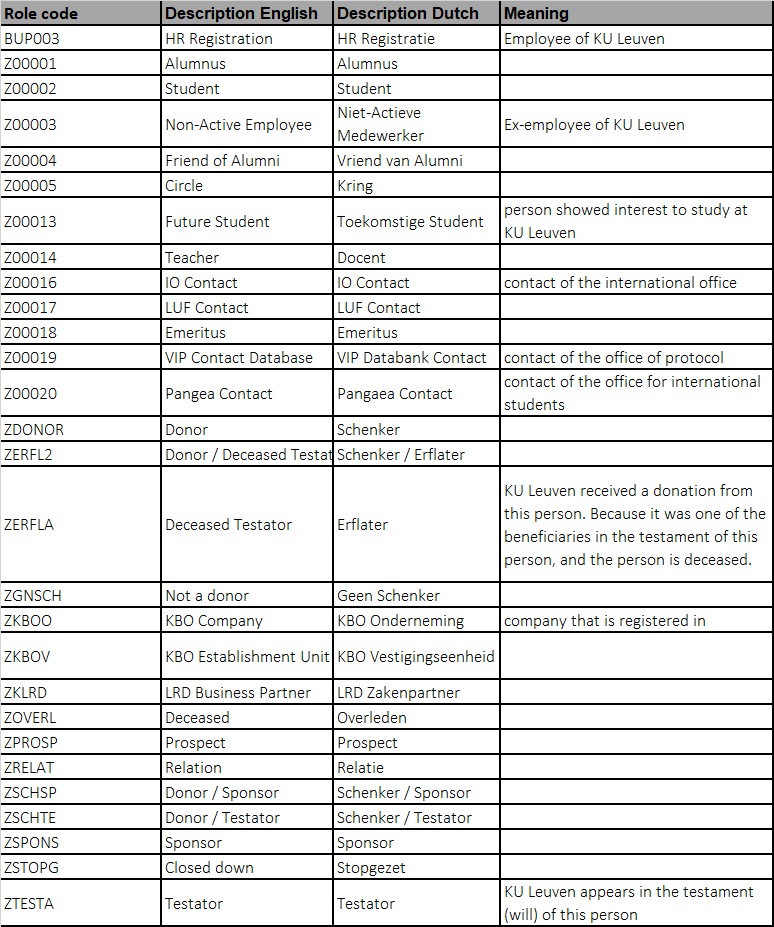

In [3]:
but100 = pd.read_csv('sqldata/20190102_BUT100.csv',dtype = str, encoding='latin-1',sep=';')
print(but100.shape)
but100.head()

(177894, 2)


,PARTNER,RLTYP
0,0201053952,Z00017
1,0201053953,Z00017
2,0201053954,Z00017
3,0201053955,Z00017
4,0201053957,Z00017


In [4]:
len(set(but100['PARTNER']))

72114

There are 72114 unique business partners in the LUF database. But not all of them are donors. A donor is a business partner that has either one of these 'RLTYP': ZDONOR, ZERFL2, ZSCHSP, ZSCHTE, ZOVERL, ZSTOPG, or ERFLA.

In [5]:
len(set(but100['RLTYP']))

27

There are 27 different roles a business partner can play. <br>
So the PARTNERxROLE matrix is of size 72114 x 27+1. +1 is for the PARTNER id itself.

In [6]:
but100['PARTNER'].value_counts()[:5]

0200336479    8
0200336626    8
0200017153    7
0200021549    7
0200007950    7
Name: PARTNER, dtype: int64

Matrix will be sparse as the max no of roles played by any business partner is 8 out of possible 27.<br>
The PARTNERxROLES matrix will be 1-177894/(72114*27) or ~91% sparse.

In [7]:
but100['RLTYP'].value_counts()[:5]

Z00017    71976
ZDONOR    56384
Z00001    16251
ZPROSP    14093
ZKBOO      5767
Name: RLTYP, dtype: int64

In [8]:
#Description of roles
required_role_cols = set(but100['RLTYP']) #Not all roles are considered. Only the 27 roles present in but100['RLTYP']
role_des = pd.read_csv('sqldata/20190102_TB003T.csv',dtype = str, encoding='latin-1',sep=';')
role_des = role_des[['ROLE','RLTXT']][(role_des['SPRAS']=='E') & (role_des['ROLE'].isin(required_role_cols))] #isin = in operator
role_des = role_des.sort_values(['ROLE','RLTXT'], ascending=[1, 1])
role_des.reset_index(drop=True,inplace=True)
role_des

,ROLE,RLTXT
0,BUP003,HR Registration
1,Z00001,Alumnus
2,Z00002,Student
3,Z00003,Niet-Actieve Medewerker
4,Z00004,Vriend van Alumni
5,Z00005,Kring
6,Z00013,Student
7,Z00016,IO Contact
8,Z00017,LUF Contact
9,Z00018,Emeritus


In [9]:
but100['IS_PRESENT'] = 1 #dummy variable to be used as a value in the matrix
but100.head()

,PARTNER,RLTYP,IS_PRESENT
0,0201053952,Z00017,1
1,0201053953,Z00017,1
2,0201053954,Z00017,1
3,0201053955,Z00017,1
4,0201053957,Z00017,1


In [10]:
partner_roles_matrix = pd.crosstab(index = but100.iloc[:,0], columns = but100.iloc[:,1])
partner_roles_matrix['PARTNER'] = partner_roles_matrix.index
partner_roles_matrix.reset_index(drop=True, inplace=True)
matrix_cols = ['PARTNER'] + list(required_role_cols)
partner_roles_matrix = partner_roles_matrix[matrix_cols]
print(partner_roles_matrix.shape)
partner_roles_matrix.head()

(72114, 28)


RLTYP,PARTNER,ZKBOO,BUP003,Z00016,Z00019,ZGNSCH,ZSCHTE,Z00018,Z00013,ZERFL2,...,ZPROSP,Z00004,Z00005,Z00003,ZKBOV,ZRELAT,ZDONOR,ZERFLA,ZSTOPG,ZTESTA
0,0200000002,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0200000004,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0200000005,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0200000006,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0200000007,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [11]:
partner_roles_matrix = partner_roles_matrix.fillna(0)
print(partner_roles_matrix.shape)
partner_roles_matrix.head()

(72114, 28)


RLTYP,PARTNER,ZKBOO,BUP003,Z00016,Z00019,ZGNSCH,ZSCHTE,Z00018,Z00013,ZERFL2,...,ZPROSP,Z00004,Z00005,Z00003,ZKBOV,ZRELAT,ZDONOR,ZERFLA,ZSTOPG,ZTESTA
0,0200000002,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0200000004,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0200000005,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0200000006,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0200000007,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [12]:
partner_roles_matrix.to_csv('SQLDATA/PYTHON_OUTPUTS/Roles_p_r_matrix.csv') #Save this matrix